#Test Distributions

For this study we need a set of test distributions that cover a variaty of different shapes. We chose the following distributions...

1. Single Gaussian
2. Bi-Maxwellian
3. TRANSP Distribution

Each test distribution is normalized such that the integral over E-p space is equal to $1 \times 10^{12}$ fast-ions/cm³

In [1]:
using VSTom
using PyPlot

In [4]:
a = read_ncdf("data/reduced_synthetic_transfer_matrix.cdf")
transfer_matrix = a["transfer_matrix"]
energy = a["energy"]
nenergy = length(energy)

pitch = a["pitch"]
npitch = length(pitch)

dE = abs(energy[2]-energy[1]);
dP = abs(pitch[2]-pitch[1]);
E = ones(npitch)*energy';
P = pitch*ones(nenergy)';

##Single Gaussian

This distribution allows us to see if the algorithms can reconstruct a simple distribution

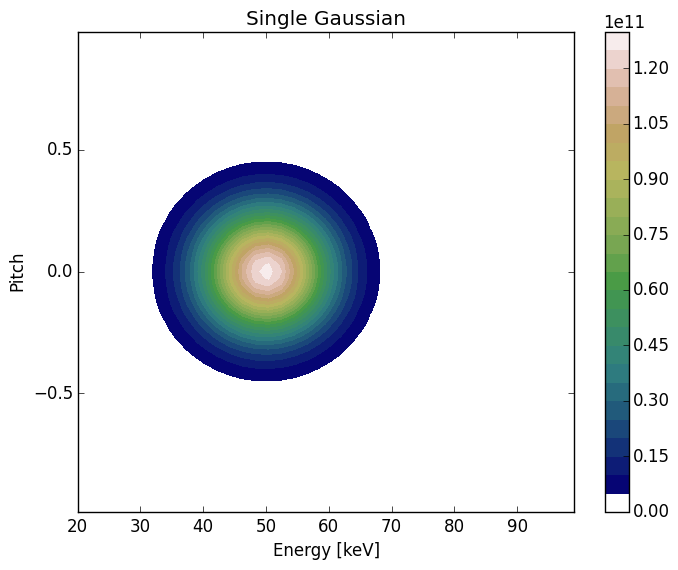

PyObject <matplotlib.colorbar.Colorbar object at 0x7f51af9a4d68>

In [2]:
gaussian = exp(-(((E-50.0)/10.0).^2 + ((P/0.25).^2) ))
gaussian *= (1e12)/(sum(gaussian)*dE*dP)

c_map = plt.cm[:get_cmap]("gist_earth")
c_map[:set_under]("w")
fig,ax  = plt.subplots()
p = ax[:contourf](E,P,gaussian,30,cmap = c_map,vmin=3e9)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Single Gaussian")
fig[:colorbar](p)

##Bi-Maxwellian

This is a common fast-ion distribution in RF heated plasmas. 

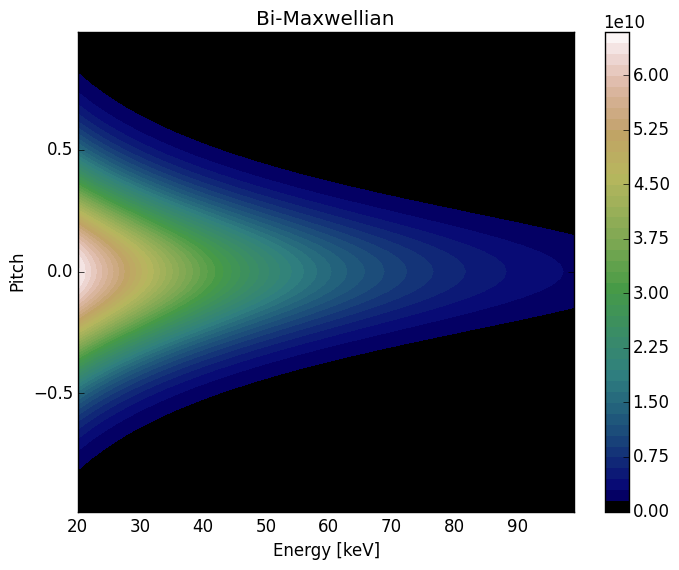

PyObject <matplotlib.colorbar.Colorbar object at 0x7f518a808908>

In [3]:
Epara = 3.0
Eperp = 20.0

bimax = ((1e12)/sqrt(pi))*(1.0/Eperp)*(1.0/sqrt(Epara))*sqrt(E).*exp(-(P.*P.*E/Epara)).*exp(-((1-P.*P).*E/Eperp))
bimax *= 1e12/(sum(bimax)*dE*dP)

c_map = plt.cm[:get_cmap]("gist_earth")
c_map[:set_under]("w")
fig,ax  = plt.subplots()
p = ax[:contourf](E,P,bimax,50,cmap=c_map,vmin=5e8)
ax[:set_xlabel]("Energy [keV]")
ax[:set_ylabel]("Pitch")
ax[:set_title]("Bi-Maxwellian")
fig[:colorbar](p)

##TRANSP

Like the Bi-Maxwellian this TRANSP distribution is representative of a typical beam heated plasma

In [4]:
using Grid
function bilinear(A,x,y,xx,yy)
    nx = length(x)
    xrange = linrange(x[1],x[end],nx)

    ny = length(y)
    yrange = linrange(y[1],y[end],ny)

    Ai = Grid.CoordInterpGrid((yrange,xrange),A,Grid.BCnearest,Grid.InterpLinear)

    nxx = length(xx)
    nyy = length(yy)
    Ap = zeros(nyy,nxx)

    for (xi, xp) in enumerate(xx)
        for (yi,yp) in enumerate(yy)
            Ap[yi,xi] = Ai[yp,xp]
        end
    end

    return Ap
end

bilinear (generic function with 1 method)

In [6]:
b = read_ncdf("data/transp.cdf")
transp = bilinear(b["MEAN_FBM"]',b["ENERGY"],b["PITCH"],energy,pitch)
transp *= 1e12/(sum(transp)*dE*dP)
b = 0; gc() #clear a variable

# c_map = plt.cm[:get_cmap]("gist_earth")
# c_map[:set_under]("w")

# fig,ax  = plt.subplots()
# p = ax[:contourf](E, P, transp, 30, cmap=c_map,vmin=4e8)
# ax[:set_xlabel]("Energy [keV]")
# ax[:set_ylabel]("Pitch")
# ax[:set_title]("TRANSP")
# fig[:colorbar](p)

##Save test distributions

In [7]:
using NetCDF

# Write transfer matrix to file
fname = "data/test_distributions.cdf"

isfile(fname) && rm(fname)

E_id = NcDim("ne",nenergy)
P_id = NcDim("np",npitch)

gauss_varid = NcVar("gaussian",[P_id,E_id])
bimax_varid = NcVar("bimax",[P_id,E_id])
transp_varid = NcVar("transp",[P_id,E_id])
e_varid = NcVar("E",[P_id,E_id])
p_varid = NcVar("P",[P_id,E_id])

ncid = NetCDF.create(fname,[gauss_varid,bimax_varid,transp_varid,e_varid,p_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"gaussian",gaussian)
NetCDF.putvar(ncid,"bimax",bimax)
NetCDF.putvar(ncid,"transp",transp)
NetCDF.putvar(ncid,"E",E)
NetCDF.putvar(ncid,"P",P)

NetCDF.close(ncid)

65536

#Synthetic Test Data

##Error Model
In experiments it is not possible to measure a single spectral component. The measured signal is comprised of active signal and background signal. To seperate out the active signal we have to have at least two measurements. A measurements of the active plus background signal and a background only signal. Subtracting the two signals will isolate the active signal.

The subtraction causes an interesting effect to the estimated error. When the active signal is large compared to the background the error primarely associated with the active signal. When the active signal is small compared the background the error is associated with the background signal. The error is also assumed to be gaussian-like. To generate test spectra from our test distributions we must be able to replicate this type of behavior. 

We propose the following model that has the correct behavior.

$$\sigma_A(\lambda) = \mathcal{S} * \max (\sqrt{A(\lambda)},\sqrt{B(\lambda)} ) * \mathcal{N}(0,1)$$

Where $\mathcal{S}$ is a scale factor. A convienient choice of $\mathcal{S}$ is $n*\mathrm{mean}(\sqrt{A(\lambda)})$. With this choice of $\mathcal{S}$, the factor $n$ can be thought of as the percentage of the mean value of $A$ which is useful for quantifying error levels.

In [2]:
function make_synthetic_data{T<:Real}(A::Array{T,2},dist::Array{T,2},n::T,b::T,dE::T,dP::T)
    y = (dE*dP) * (A*reshape(dist,length(dist)))
    
    scale = n*mean(sqrt(y))
    yerr = scale .* max(sqrt(y),sqrt(b)) .* randn(length(y))
    
    noisy_spectrum = y .+ yerr
    noisy_background = b .+ scale*sqrt(b).*randn(length(y))
    
    scale_est = n*mean(sqrt(abs(noisy_spectrum)))
    
    err = scale_est .* max(sqrt(abs(noisy_spectrum)),sqrt(abs(noisy_background)))
    
    return noisy_spectrum, err
end

make_synthetic_data (generic function with 1 method)

###No Background
Error is dominatated by active signal causing an error profile that correlates with the signal profile.

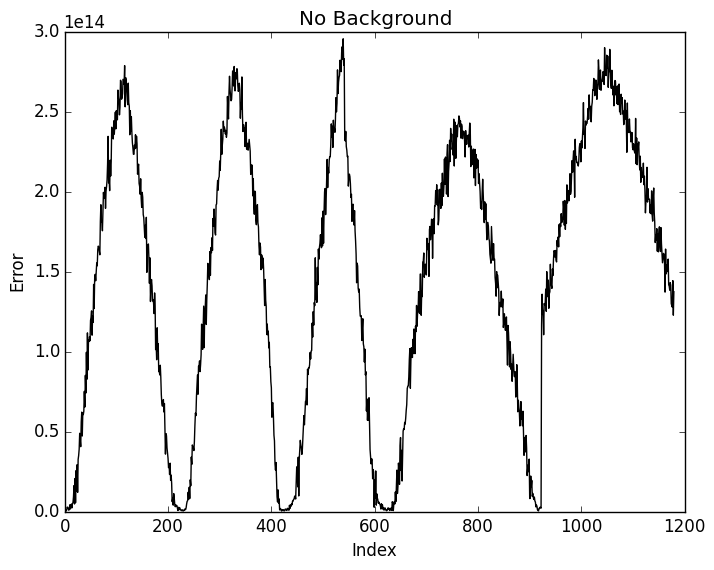

In [5]:
dist = ones(npitch,nenergy)
dist *= (1e12)/sum(dist*dE*dP)
spec,err = make_synthetic_data(transfer_matrix,dist,.1,0.0,dE,dP);
plot(err,"k")
title("No Background")
xlabel("Index")
ylabel("Error")
savefig("/home/lstagner/conferences/IAEA2015/no_background.png")

###Typical Constant Background
This represents a typical experimental error profile where the background error dominates at relativively low active signal and active error dominates at relativively high active signal.

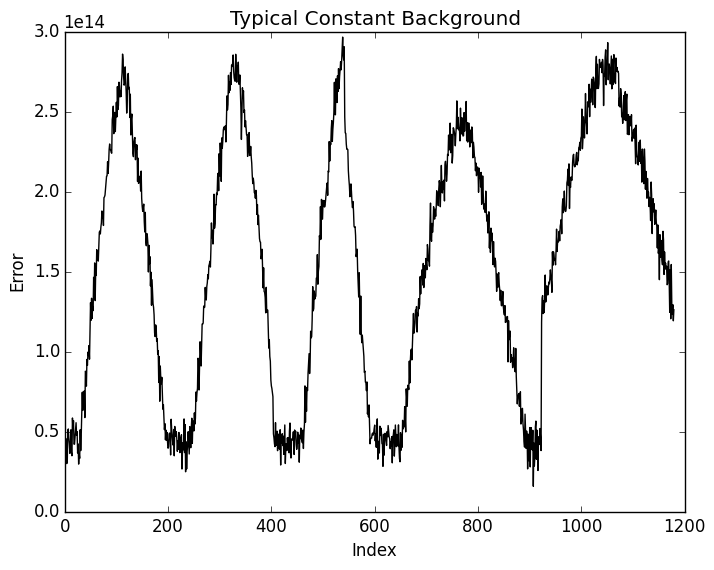

In [6]:
spec,err = make_synthetic_data(transfer_matrix,dist,.1,1.25e14,dE,dP);
plot(err,"k")
title("Typical Constant Background")
xlabel("Index")
ylabel("Error")
savefig("/home/lstagner/conferences/IAEA2015/mid_background.png")

###High Constant Background
Error from background dominates causing a flat error profile

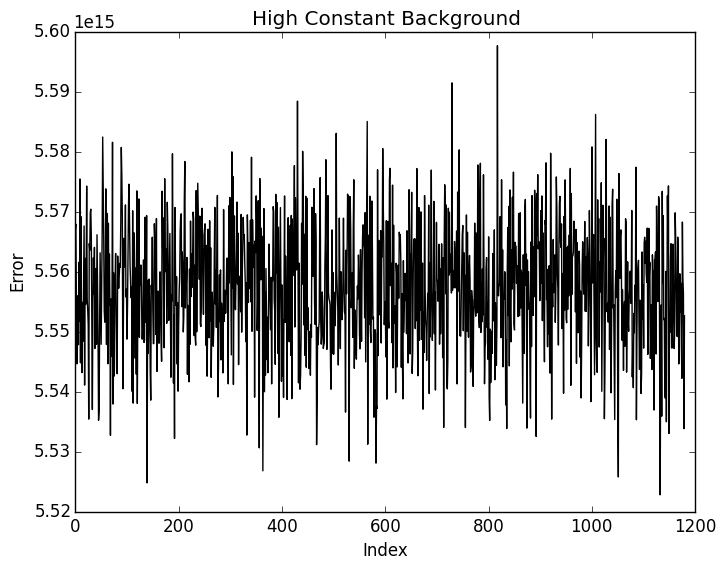

In [7]:
spec,err = make_synthetic_data(transfer_matrix,dist,.1,1e18,dE,dP);
plot(err,"k")
title("High Constant Background")
xlabel("Index")
ylabel("Error")
savefig("/home/lstagner/conferences/IAEA2015/high_background.png")

##Generate Synthetic Test Data

In [14]:
# Get size of transfer matrix
nrows,ncols = size(transfer_matrix)

# Allocate storage
gauss_spec = zeros(nrows,21)
gauss_err = zeros(nrows,21)
bimax_spec = zeros(nrows,21)
bimax_err = zeros(nrows,21)
transp_spec = zeros(nrows,21)
transp_err = zeros(nrows,21)

# Generate synthetic data for varying error levels with the same background value
for (ind,n) in enumerate(0:.05:1)
    gauss_spec[:,ind], gauss_err[:,ind] = make_synthetic_data(transfer_matrix,gaussian,n,1.25e14,dE,dP);
    bimax_spec[:,ind], bimax_err[:,ind] = make_synthetic_data(transfer_matrix,bimax,n,1.25e14,dE,dP);
    transp_spec[:,ind], transp_err[:,ind] = make_synthetic_data(transfer_matrix,transp,n,1.25e14,dE,dP);
end

In [15]:
using NetCDF
# Write synthetic data to file
fname = "data/test_data.cdf"

isfile(fname) && rm(fname)

nrows_id = NcDim("nrows",nrows)
ncols_id = NcDim("ncols",21)

gauss_spec_varid = NcVar("gaussian_spec",[nrows_id,ncols_id])
bimax_spec_varid = NcVar("bimax_spec",[nrows_id,ncols_id])
transp_spec_varid = NcVar("transp_spec",[nrows_id,ncols_id])

gauss_err_varid = NcVar("gaussian_err",[nrows_id,ncols_id])
bimax_err_varid = NcVar("bimax_err",[nrows_id,ncols_id])
transp_err_varid = NcVar("transp_err",[nrows_id,ncols_id])

ncid = NetCDF.create(fname,[gauss_spec_varid,bimax_spec_varid,transp_spec_varid, 
    gauss_err_varid,bimax_err_varid,transp_err_varid],mode=NC_CLASSIC_MODEL)

NetCDF.putvar(ncid,"gaussian_spec",gauss_spec)
NetCDF.putvar(ncid,"bimax_spec",bimax_spec)
NetCDF.putvar(ncid,"transp_spec",transp_spec)

NetCDF.putvar(ncid,"gaussian_err",gauss_err)
NetCDF.putvar(ncid,"bimax_err",bimax_err)
NetCDF.putvar(ncid,"transp_err",transp_err)
NetCDF.close(ncid);